In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tqdm as tqdm

# Special for plotting
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import sys
import os

# # Add the poligrain and mergeplg src directories to Python's path
sys.path.append(os.path.abspath("./poligrain/src"))
sys.path.append(os.path.abspath("./mergeplg/src"))


In [4]:
# Import submodules
import pycomlink as pycml
import poligrain as plg
import mergeplg as merge


In [5]:
# OpenMRG
ds_gauges = xr.open_dataset("data/andersson_2022_OpenMRG/gauges/openmrg_gauges_city.nc")
ds_gauges_smhi = xr.open_dataset("data/andersson_2022_OpenMRG/gauges/openmrg_gauges_smhi.nc")
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc") 

In [6]:
# Slice in time 
start = '2015-08-01T00'
end = '2015-08-31T00'
ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_gauges_smhi = ds_gauges_smhi.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 


In [7]:
ds_rad["rainfall_amount"] = ds_rad['R'] * (5 / 60)
# Resample to 15 min resolution
ds_rad = ds_rad.resample(time = '15min', label='right', closed='right').sum()

ds_cmls = ds_cmls.R_acc.resample(time = '15min', label='right', closed='right').sum()
ds_cmls = ds_cmls.reduce(np.nanmean, dim='sublink_id')


In [8]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [9]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [10]:
# Project OpenMRG data
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.longitude, ds_gauges_smhi.latitude, ref_str
    )
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates( 
    ds_rad.lon, ds_rad.lat, ref_str
)

# Closest municip to SMHI

In [11]:
n_closest = 3

# Get the n closest netatmo to SMHI
closest = plg.spatial.get_closest_points_to_point(
    ds_gauges_smhi,
    ds_gauges,
    max_distance=10000,
    n_closest = n_closest
).isel(id = 0).neighbor_id.data

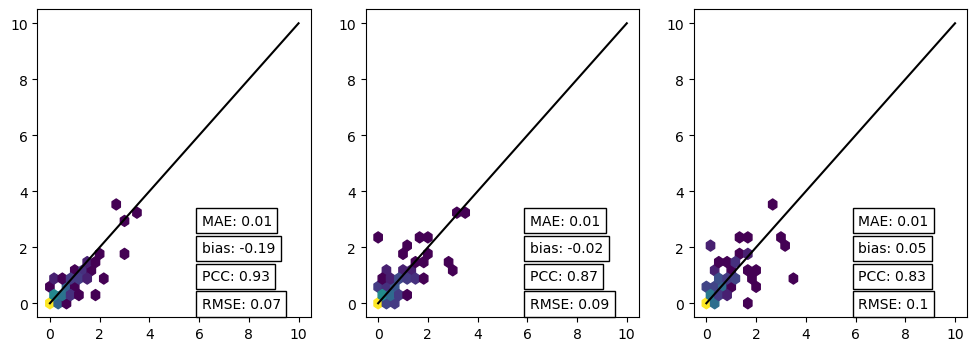

In [12]:
fig, ax = plt.subplots(1, n_closest, figsize=(n_closest*4,4))
for i, id in enumerate(closest):
    ground = ds_gauges_smhi.rainfall_amount.isel(id = 0).data
    tar = ds_gauges.rainfall_amount.sel(id = id).data
    keep = np.ones(tar.size).astype(bool)
    ax[i].hexbin(
        ground,
        tar,
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[i].plot([0, 10], [0, 10], 'k')

    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )


# Closest CMLs to SMHI

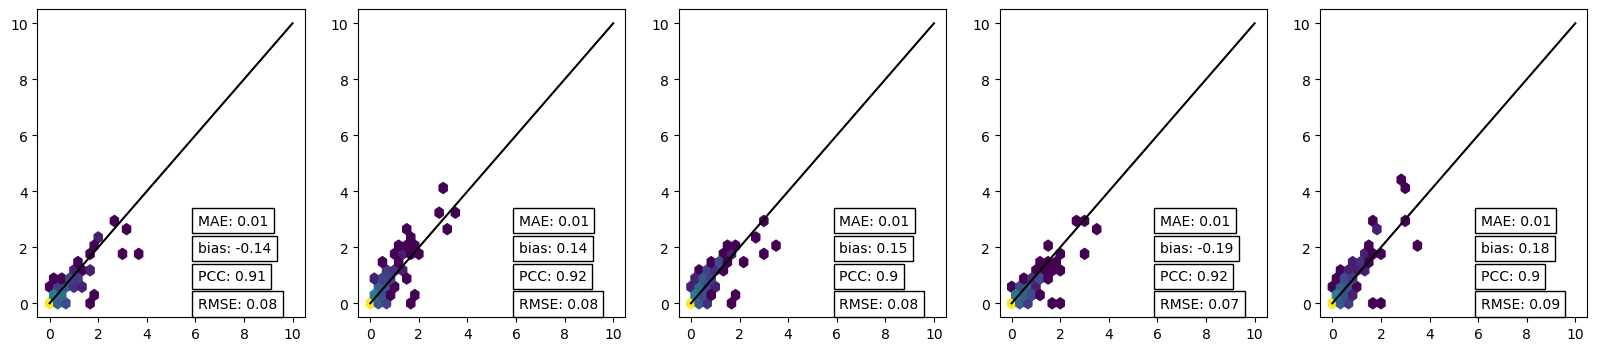

In [13]:
n_closest = 5
cml_rain = ds_cmls.sel(time=ds_gauges_smhi.time)


# Get the n closest netatmo to SMHI
closest = plg.spatial.get_closest_points_to_point(
    ds_gauges_smhi,
    ds_cmls.rename({'cml_id':'id'}),
    max_distance=10000,
    n_closest = n_closest
).isel(id = 0).neighbor_id.data

fig, ax = plt.subplots(1, n_closest, figsize=(n_closest*4,4))
for i, id in enumerate(closest):
    ground = ds_gauges_smhi.rainfall_amount.isel(id = 0).data
    tar = cml_rain.sel(cml_id = id).data
    keep = np.ones(tar.size).astype(bool)
    ax[i].hexbin(
        ground,
        tar,
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[i].plot([0, 10], [0, 10], 'k')

    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )


# Adjust rainfall fields

In [14]:
time = ds_cmls.time.data[0]
print(ds_rad.sel(time=[time]).rainfall_amount.shape)
print(ds_cmls.sel(time=[time]).shape)

(1, 48, 37)
(359, 1)


In [15]:
# Additive IDW
merger = merge.merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_idw"] = xr.concat(adjusted_rainfall, dim="time")

100%|██████████| 2885/2885 [00:15<00:00, 188.84it/s]


In [16]:
# Additive Block Kriging
merger = merge.merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_bk"] = xr.concat(adjusted_rainfall, dim="time")

100%|██████████| 2885/2885 [04:04<00:00, 11.82it/s] 


In [17]:
# Block Kriging With External Drift
merger = merge.merge.MergeBlockKrigingExternalDrift()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_ked"] = xr.concat(adjusted_rainfall, dim="time")

100%|██████████| 2885/2885 [02:54<00:00, 16.58it/s] 


In [18]:
# saving adjusted fields
ds_rad.to_netcdf('data/adjusted_radar_OpenMRG.nc')

# Plot adjusted fields

In [19]:
cmap_colors = [
    (0, "white"),
    (radar_zero, "white"),
    (radar_zero, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

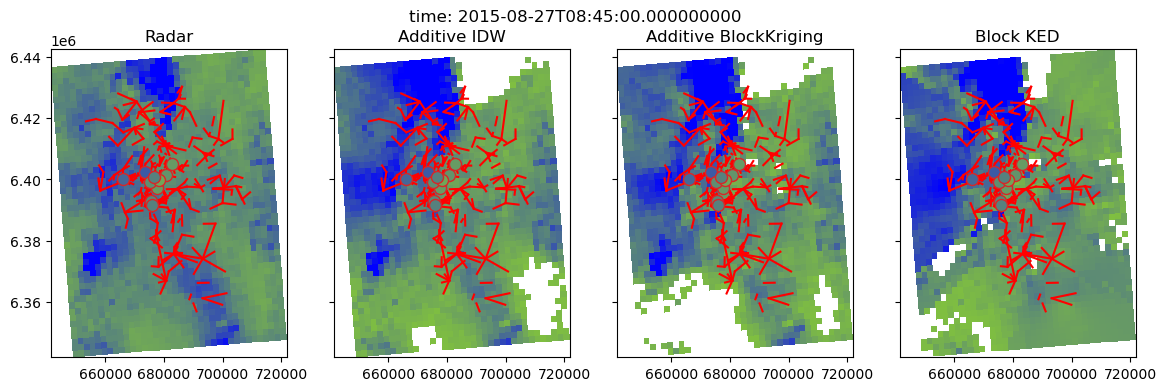

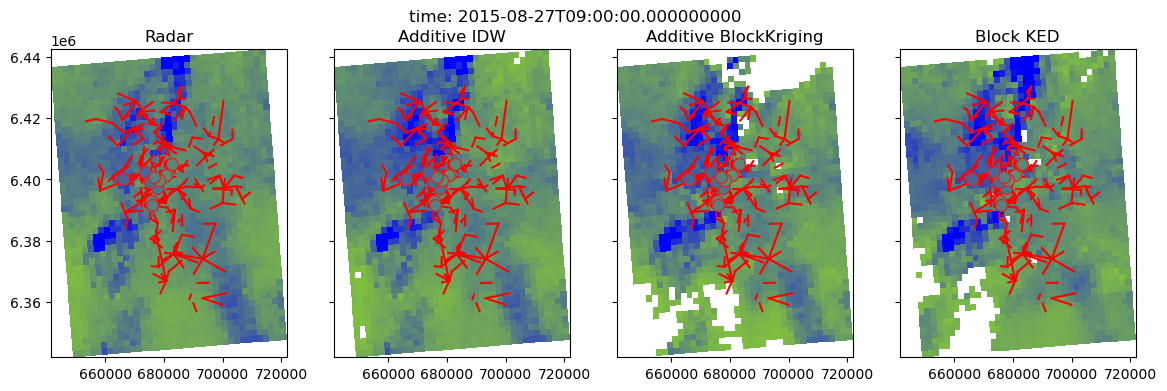

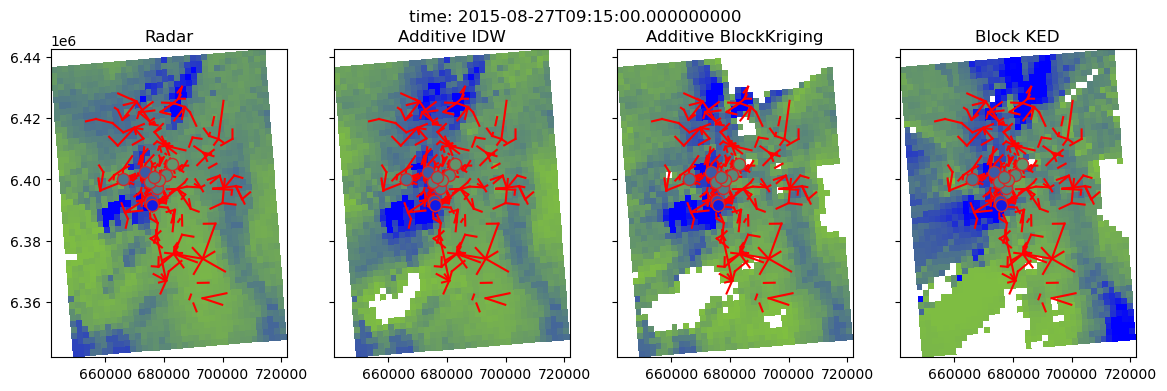

In [20]:
vmax = 3  # max color

# Time interval to plot
time_start = "2015-08-27T08:45"
time_end = "2015-08-27T09:15"
for time in ds_cmls.sel(time=slice(time_start, time_end)).time:
    fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
    ax[0].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_amount.data,
        vmin=0,
        vmax=vmax,
        cmap=cmap_rain,
    )

    ax[1].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).adjust_idw.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[2].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).adjust_bk.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[3].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).adjust_ked.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[0].set_title("Radar")
    ax[1].set_title("Additive IDW")
    ax[2].set_title("Additive BlockKriging")
    ax[3].set_title("Block KED")
    plt.suptitle('time: '+str(time.values))

    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "red",
                zorder=1,
            )

    for ax_i in range(len(ax)):
        for station_id in ds_gauges.id:
            ax[ax_i].scatter(
                station_id.x,
                station_id.y,
                c=ds_gauges.sel(id=station_id, time=time).rainfall_amount,
                cmap=cmap_rain,
                edgecolors="C3",
                vmin=0,
                vmax=vmax,
                s=75,
                zorder=2,
            )
    plt.show()

# Compare adjusted fields to CML observations

In [21]:
intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.data,
    y1_line=ds_cmls.site_0_lat.data,
    x2_line=ds_cmls.site_1_lon.data,
    y2_line=ds_cmls.site_1_lat.data,
    cml_id=ds_cmls.cml_id.data,
    x_grid=ds_rad.lon.data,
    y_grid=ds_rad.lat.data,
    grid_point_location="center",
)

ds_cmls["rainfall_radar"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.rainfall_amount,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_idw"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_idw,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_bk"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_bk,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_ked"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_ked,
    intersect_weights=intersect_weights,
)

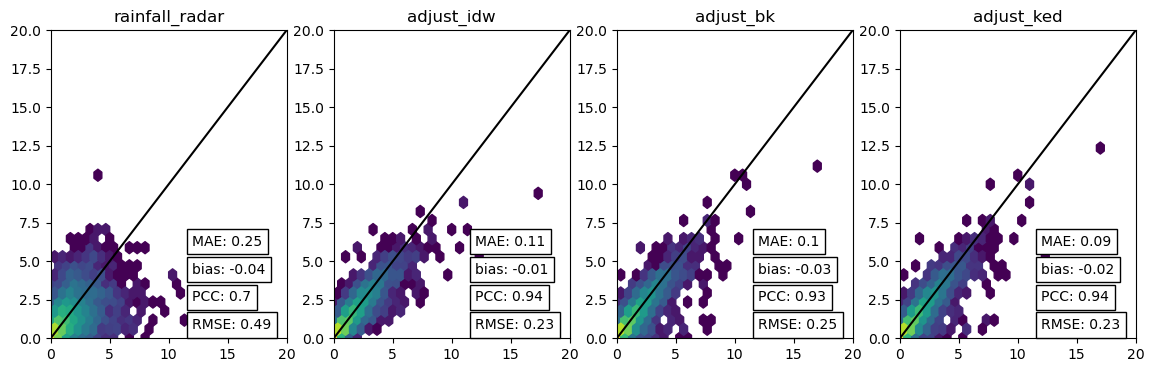

In [22]:
max_ext = 20
extent = [0, max_ext, 0, max_ext]
gridsize = 30

pred_models = [
    ds_cmls.rainfall_radar,
    ds_cmls.adjust_idw,
    ds_cmls.adjust_bk,
    ds_cmls.adjust_ked,
]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_cmls.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.T.ravel()

    keep = (ground > 0) & (tar > 0)

    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(pred_models[i].name)
    ax[i].set_xlim(0, extent[1])
    ax[i].set_ylim(0, extent[1])

# Compare to city rain gauges

In [23]:
ds_gauges = ds_gauges.rename({'longitude':'lon', 'latitude':'lat'})
ds_rad = ds_rad.sel(time=ds_gauges.time)

In [24]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best",
)

In [25]:
ds_gauges['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_idw,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_bk,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_ked,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

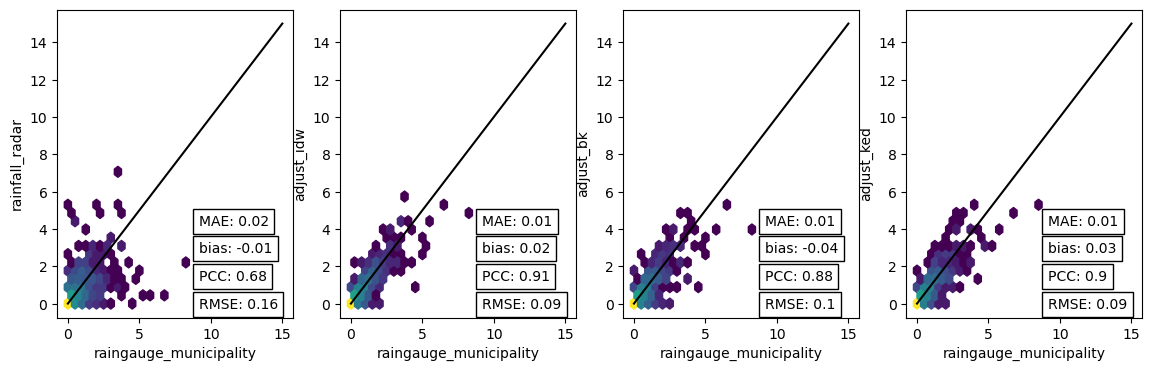

In [26]:
max_ = 15
extent = [0, max_, 0, max_]
gridsize = 30

pred_models = [ds_gauges.rainfall_radar, ds_gauges.adjust_idw, ds_gauges.adjust_bk, ds_gauges.adjust_ked]

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharex = True)
ground = ds_gauges.rainfall_amount.data.ravel()
radar_rainfall = ds_gauges.rainfall_radar.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.shape).astype(bool)
    
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")
    ax[i].set_ylabel(pred_models[i].name)
    ax[i].set_xlabel('raingauge_municipality')

plt.show()

# Compare to SMHI rain gauge

In [27]:
ds_gauges_smhi = ds_gauges_smhi.rename({'longitude':'lon', 'latitude':'lat'})
ds_rad = ds_rad.sel(time=ds_gauges_smhi.time)

In [28]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges_smhi.isel(time = 0),
    nnear=1,
    stat="best",
)

In [29]:
ds_gauges_smhi['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges_smhi['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_idw,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges_smhi['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_bk,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges_smhi['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_ked,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

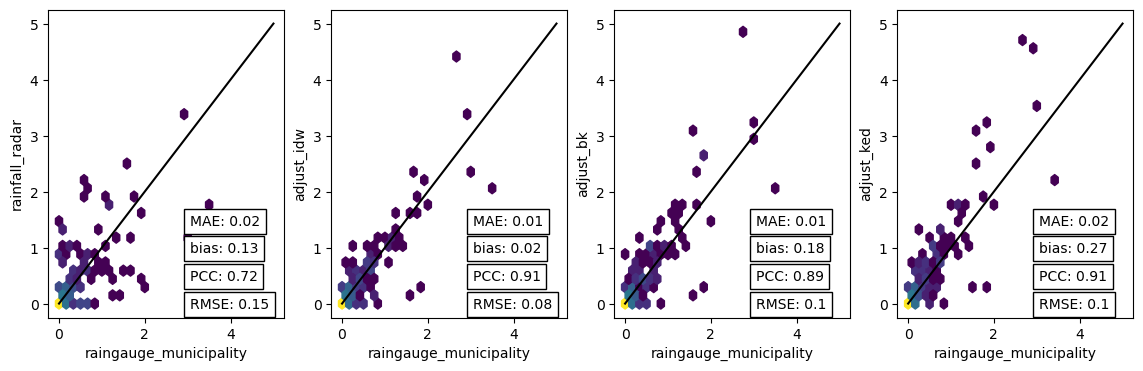

In [30]:
max_ = 5
extent = [0, max_, 0, max_]
gridsize = 30

pred_models = [ds_gauges_smhi.rainfall_radar, ds_gauges_smhi.adjust_idw, ds_gauges_smhi.adjust_bk, ds_gauges_smhi.adjust_ked]

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharex = True)
ground = ds_gauges_smhi.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()
    keep = np.ones(ground.shape).astype(bool)
    
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")
    ax[i].set_ylabel(pred_models[i].name)
    ax[i].set_xlabel('raingauge_municipality')

plt.show()

# OpenRainER

In [31]:
# OpenRainER
ds_gauges = xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc")
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc") 

# Slice in time 
start = '2022-08-01T00'
end = '2022-08-31T00'
ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 

In [32]:
# Resample to 15 min resolution
ds_cmls = ds_cmls.R_acc.resample(time = '15min', label='right', closed='right').sum()
ds_cmls = ds_cmls.reduce(np.nanmean, dim='sublink_id')

# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

In [33]:
ref_str = "EPSG:32632"

# Project OpenRainER data
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, ref_str
)

(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates( 
    ds_rad.lon_grid, ds_rad.lat_grid, ref_str
)

In [ ]:
ds_cmls = ds_cmls.sel(time=ds_rad.time)
ds_rad = ds_rad.rename({'lon':'x', 'lat':'y'})
ds_rad = ds_rad.rename({'lon_grid':'lon', 'lat_grid':'lat'})

In [35]:
# Additive IDW
merger = merge.merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_idw"] = xr.concat(adjusted_rainfall, dim="time")

100%|██████████| 2884/2884 [00:25<00:00, 112.91it/s]


In [36]:
# Additive Block Kriging
merger = merge.merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_bk"] = xr.concat(adjusted_rainfall, dim="time")

100%|██████████| 2884/2884 [15:32<00:00,  3.09it/s]  


In [37]:
# Block Kriging With External Drift
merger = merge.merge.MergeBlockKrigingExternalDrift()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_ked"] = xr.concat(adjusted_rainfall, dim="time")

100%|██████████| 2884/2884 [08:55<00:00,  5.39it/s]  


In [38]:
# saving adjusted fields
ds_rad.to_netcdf('data/adjusted_radar_OpenRainER.nc')

# Compare adjusted fields to CML observations

In [39]:
intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.data,
    y1_line=ds_cmls.site_0_lat.data,
    x2_line=ds_cmls.site_1_lon.data,
    y2_line=ds_cmls.site_1_lat.data,
    cml_id=ds_cmls.cml_id.data,
    x_grid=ds_rad.lon.data,
    y_grid=ds_rad.lat.data,
    grid_point_location="center",
)

ds_cmls["rainfall_radar"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.rainfall_amount,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_idw"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_idw,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_bk"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_bk,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_ked"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_ked,
    intersect_weights=intersect_weights,
)

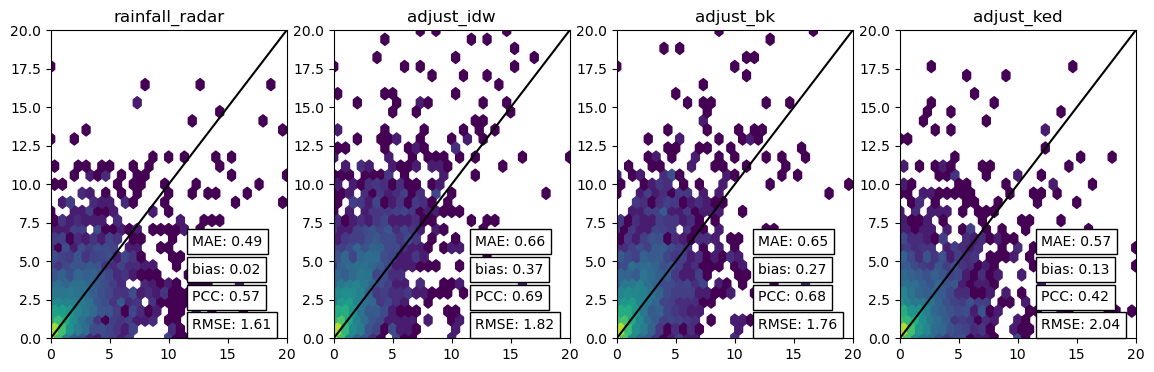

In [40]:
max_ext = 20
extent = [0, max_ext, 0, max_ext]
gridsize = 30

pred_models = [
    ds_cmls.rainfall_radar,
    ds_cmls.adjust_idw,
    ds_cmls.adjust_bk,
    ds_cmls.adjust_ked,
]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_cmls.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.T.ravel()

    keep = (ground > 0) & (tar > 0)

    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(pred_models[i].name)
    ax[i].set_xlim(0, extent[1])
    ax[i].set_ylim(0, extent[1])

# Compare to rain gauge

In [41]:
ds_gauges = ds_gauges.rename({'longitude':'lon', 'latitude':'lat'})
ds_rad = ds_rad.sel(time=ds_gauges.time)

In [42]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best",
)

In [43]:
ds_gauges['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_idw,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_bk,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_ked,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

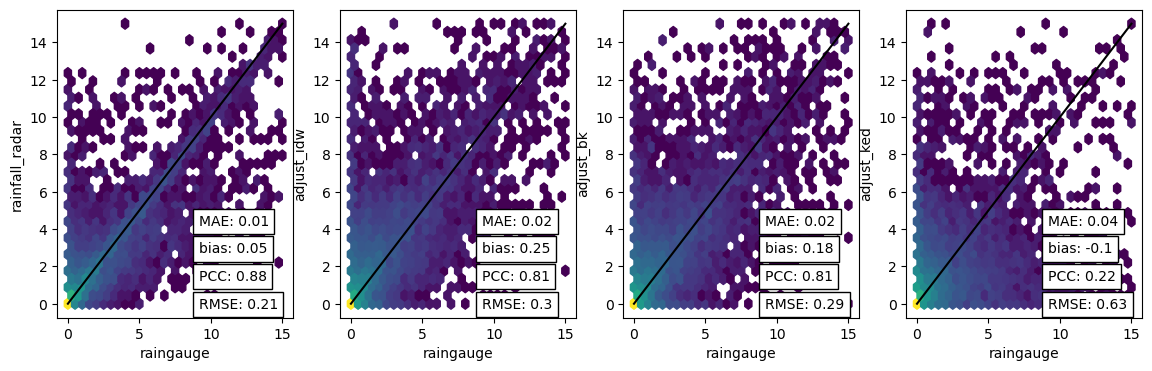

In [44]:
max_ = 15
extent = [0, max_, 0, max_]
gridsize = 30

pred_models = [ds_gauges.rainfall_radar, ds_gauges.adjust_idw, ds_gauges.adjust_bk, ds_gauges.adjust_ked]

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharex = True)
ground = ds_gauges.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = ~np.isnan(ground) & ~np.isnan(tar)
    
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")
    ax[i].set_ylabel(pred_models[i].name)
    ax[i].set_xlabel('raingauge')

plt.show()